# Total cases and deaths for several country based on available data

In [19]:
from bs4 import BeautifulSoup
from requests import get
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import re
import os

%matplotlib inline

### ECDC data

In [6]:
# Another sources but no information on data source
ecdc_url = "https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide"
response = get(ecdc_url)

# Since the link changes daily, let's make some soup
soup = BeautifulSoup(response.text, 'html.parser')
ecdc_data_url = soup.find('a', attrs={'href': re.compile("^https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-")}).get('href')

ecdc_data = pd.read_excel(ecdc_data_url)
ecdc_data['source'] = 'ecdc'

# Renaming columns
ecdc_data.rename(columns={'DateRep':'date', 'Countries and territories':'country', 'Cases':'new_cases', 'Deaths':'new_deaths'}, inplace=True)

# Name correction...
ecdc_data.loc[ecdc_data.country=='United States of America', 'country'] = 'U.S.A'

# Date conversion
ecdc_data['date'] = pd.to_datetime(ecdc_data['date'])
ecdc_data.sort_values(by='date', inplace=True)

# Totals had to be calculated
ecdc_data['total_cases'] = ecdc_data.groupby('country')['new_cases'].cumsum()
ecdc_data['total_deaths'] = ecdc_data.groupby('country')['new_deaths'].cumsum()

# Fatality rates
ecdc_data['case_fatality_rate'] = 100*(ecdc_data.total_deaths/ecdc_data.total_cases)

# Keeping only those of interests
ecdc_data = ecdc_data.filter(['date', 'country', 'total_cases', 'total_deaths', 'source', 'case_fatality_rate'])




### Epidemy start offset

Since each country have had different start dates regarding this epidemy, we  offset the dates by the date with a certain number of cases/deaths identified in ECDC data (since they have the most history) for each country.

In [7]:
number_of_cases_for_offset = 100
number_of_deaths_for_offset = 50

# Country with at least one cases
country_gt_one_case = ecdc_data[(ecdc_data.total_cases>number_of_cases_for_offset) & (ecdc_data.total_cases>number_of_deaths_for_offset)].groupby('country').head(1).country.unique()
ecdc_data = ecdc_data[ecdc_data.country.isin(country_gt_one_case)]

# Looking for offsets
china_start_date = pd.Timestamp('2019-12-31') # For future use
country_offset_date_cases = dict(ecdc_data[(ecdc_data.total_cases>number_of_cases_for_offset)].groupby('country').head(1)[['country', 'date']].values)
country_offset_date_deaths = dict(ecdc_data[(ecdc_data.total_cases>number_of_deaths_for_offset)].groupby('country').head(1)[['country', 'date']].values)

### Merging the data

We merge WHO and ECDC data and add a column with the days since first case for each country.

We only keep the countries appearing in both.

In [8]:
data = pd.melt(ecdc_data, 
                         id_vars=['date', 'country', 'source'], 
                         value_vars=['total_cases', 'total_deaths', 'case_fatality_rate'])

data['offset_cases'] = data.apply(lambda x: (x['date'] - country_offset_date_cases[x['country']]).days, axis=1)  
data['offset_deaths'] = data.apply(lambda x: (x['date'] - country_offset_date_deaths[x['country']]).days, axis=1)  


## Plots

In [9]:
countries_to_plot = ['France', 'Spain', 'Italy', 'China', 'U.S.A', 'South_Korea']
data_plot = data[data.country.isin(countries_to_plot)]

### Total cases and deaths since the first case for each country

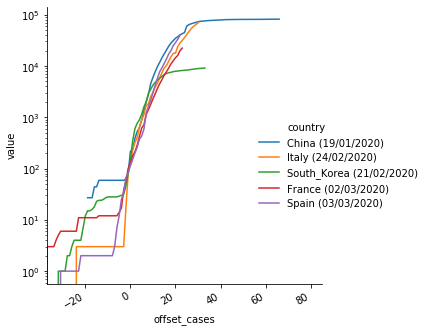

In [33]:
g = sns.relplot(x='offset_cases', y='value',
                kind='line',
                hue='country',
                data=data_plot[data_plot.variable=='total_cases'])
g.fig.autofmt_xdate()
g.set(yscale='log')
g.set(xlim=(min(data[(data.variable=='total_cases') & (data.value>0) & (data.country.isin(countries_to_plot))]['offset_cases']),(pd.to_datetime('today')-china_start_date).days))
for t in g._legend.texts[1:]:
    t.set_text("{} ({})".format(t.get_text(), country_offset_date_cases[t.get_text()].strftime('%d/%m/%Y')))


plt.savefig('./Total_cases.png')
plt.show()

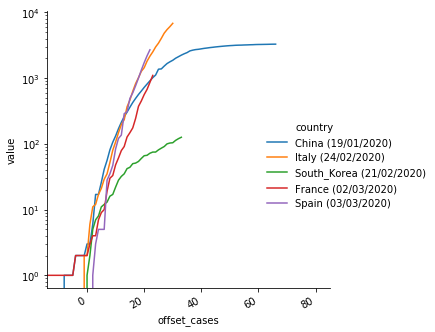

In [11]:
g = sns.relplot(x='offset_cases', y='value',
                kind='line',
                hue='country',
                data=data_plot[data_plot.variable=='total_deaths'])
g.fig.autofmt_xdate()
g.set(yscale='log')
g.set(xlim=(min(data[(data.variable=='total_deaths') & (data.value>0) & (data.country.isin(countries_to_plot))]['offset_deaths']),(pd.to_datetime('today')-china_start_date).days))

for t in g._legend.texts[1:]:
    t.set_text("{} ({})".format(t.get_text(), country_offset_date_cases[t.get_text()].strftime('%d/%m/%Y')))

plt.savefig('./Total_deaths.png')
plt.show()

### Morbidity

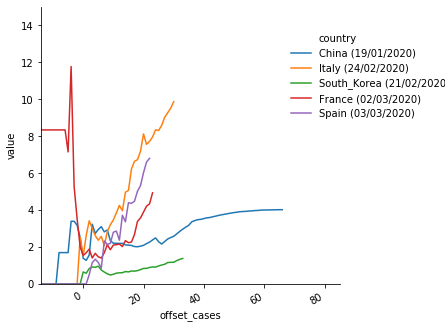

In [12]:
g = sns.relplot(x='offset_cases', y='value',
                kind='line',
                hue='country',
                data=data_plot[data_plot.variable=='case_fatality_rate'])
g.fig.autofmt_xdate()
g.set(xlim=(min(data[(data.variable=='total_deaths') & (data.value>0) & (data.country.isin(countries_to_plot))]['offset_deaths']),(pd.to_datetime('today')-china_start_date).days))
g.set(ylim=(0,15))

for t in g._legend.texts[1:]:
    t.set_text("{} ({})".format(t.get_text(), country_offset_date_cases[t.get_text()].strftime('%d/%m/%Y')))
g.fig.get_children()[-1].set_bbox_to_anchor((1, 0.7, 0, 0))

plt.savefig('Morbidity.png')
plt.show()

### Linear y-axis

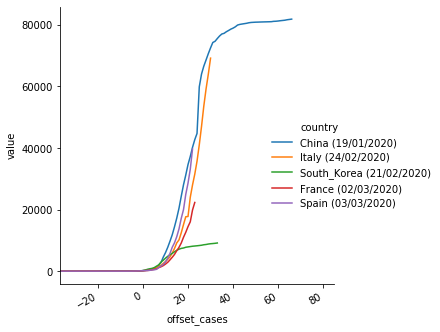

In [13]:
g = sns.relplot(x='offset_cases', y='value',
                kind='line',
                hue='country',
                data=data_plot[data_plot.variable=='total_cases'])
g.fig.autofmt_xdate()
g.set(xlim=(min(data[(data.variable=='total_cases') & (data.value>0) & (data.country.isin(countries_to_plot))]['offset_cases']),(pd.to_datetime('today')-china_start_date).days))

for t in g._legend.texts[1:]:
    t.set_text("{} ({})".format(t.get_text(), country_offset_date_cases[t.get_text()].strftime('%d/%m/%Y')))

plt.savefig('./Total_cases_lin.png')
plt.show()

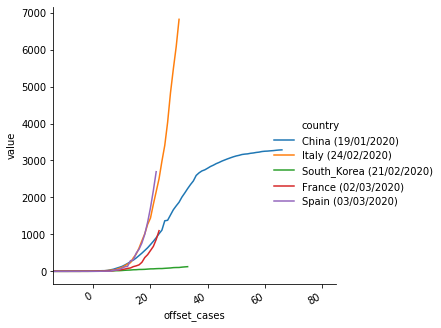

In [14]:
g = sns.relplot(x='offset_cases', y='value',
                kind='line',
                hue='country',
                data=data_plot[data_plot.variable=='total_deaths'])
g.fig.autofmt_xdate()
g.set(xlim=(min(data[(data.variable=='total_deaths') & (data.value>0) & (data.country.isin(countries_to_plot))]['offset_deaths']),(pd.to_datetime('today')-china_start_date).days))

for t in g._legend.texts[1:]:
    t.set_text("{} ({})".format(t.get_text(), country_offset_date_cases[t.get_text()].strftime('%d/%m/%Y')))

plt.savefig('./Total_deaths_lin.png')
plt.show()